## LEARNING MACHINE LEARNING 2018

# Lab 8: Convolutional Neural Networks (CNNs)

**Universidad del Rosario**<br>
**July 26, 2018**<br>
**Instructors: Pavlos Protopapas, Rafael Martinez, Juan Fernando Perez, Dora Suarez, Juan Felipe Giraldo, Dora Suarez, Julian Rincon, German Obando**

Some of the text and material for this lab comes from:
https://xrds.acm.org/blog/2016/06/convolutional-neural-networks-cnns-illustrated-explanation/
https://www.kaggle.com/ernie55ernie/mnist-with-keras-visualization-and-saliency-map/notebook

### Generalities

Often in machine learning applications involving images (such as image classification, automatic image captioning, object dection, recognition or scene labeling) the first task is to parse an image into a set of 'features' that are relevant for the task at hand. That is, we prefer not to work with images as a set of pixels. **Question:** can you think of some reasons for why this is? Traditionally, the set of relevant features to extract from raw images need to be defined before hand using domain expertise and then must be 'engineered' (computed) from the images represented as pixels. For example, for training a model to distinguish a night scene from a day scene, one might want to compare the color histograms of two images. The problem with the approach of feature engineering is that, a priori, it can be difficult to know what type of features best facilitate the performance of a given task, furthermore, the features one has engineered to optimize one task may not generalize to help accomplish another.

Neural networks provide a natural and flexible framework for extracting useful features from raw images. Often, while training a NN to accomplish a particular task (like classification) we get, from this process, a useful alternate representaiton of the data. Taking this intuition further, we ask whether or not we can use a neural network to automatically extract useful features (or alternate representations) from the data by optimizing the network for a particular task.

In this lab, we will consider a particular type of neural network, the convolutional network (CNN), that is especially suited for feature extraction of image data. A CNN is a neural network typically composed of two components, one component for extracting useful features of the data, and another for performing a ML task (like classification based on the featurized data:

<img src="cnn.png" style="width: 700px;" align="center"/>

The feature extracting layers are called **convolutional layers**, each node in these layers uses a small fixed set of weights to transform the image in the following way:

<img src="convolution_layer.gif" style="width: 600px;" align="center"/>

This set of fixed weights for each node in the convolutional layer is often called a ***filter*** or a ***kernel***. The term "filter" comes from image processing where one has standard ways to transforms raw images:

<img src="filter_apply.gif" style="width: 600px;" align="center"/>

In [14]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import matplotlib.image as  mpimg
from PIL import Image

#from subprocess import check_output

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

### Preparing the dataset

The first thing we do is to load our dataset. Once again, we will do this exercise with the MNIST dataset of handwritten digits. Keras allows us to load it already split in training and testing sets, but we will do to things differently now: We will use only a small fraction (10%) of the entire dataset to save computational costs during training:

In [ ]:
print(os.listdir("/Users/jvivas"))

# Data preparation
### Get images path

In [6]:
# Define path to the data directory
data_dir = Path('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [7]:
normal_casos_dir = train_dir / 'NORMAL'
pneumonia_casos_dir = train_dir / 'PNEUMONIA'

# put the images in a list
normal_casos_lista = normal_casos_dir.glob('*.jpeg')
pneumonia_casos_lista = pneumonia_casos_dir.glob('*.jpeg')

train_data = []

# agregamos la label a cada foto
for img in normal_casos_lista:
    train_data.append((img,0))

for img in pneumonia_casos_lista:
    train_data.append((img,1))
    
# usemos pandas para manejar la data
train_data_df = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# hagamos Shuffle para que el algoritmo no coga las mismas datos siempre
train_data_df = train_data_df.sample(frac=1.).reset_index(drop=True)

train_data_df.head()

,image,label
0,/Users/jvivas/Documents/Kaggle/XRay Pneumonia/...,1
1,/Users/jvivas/Documents/Kaggle/XRay Pneumonia/...,0
2,/Users/jvivas/Documents/Kaggle/XRay Pneumonia/...,0
3,/Users/jvivas/Documents/Kaggle/XRay Pneumonia/...,1
4,/Users/jvivas/Documents/Kaggle/XRay Pneumonia/...,1


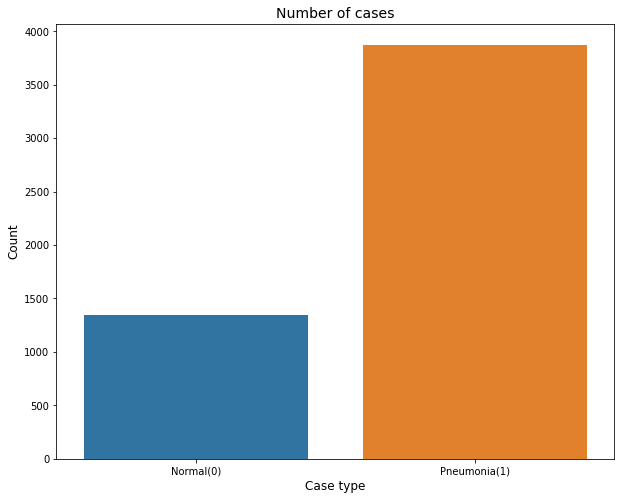

In [9]:
# Veamos los datos por clases

cases_count = train_data_df['label'].value_counts()

# Plotting resultados
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [12]:
samples

[PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/PNEUMONIA/person392_bacteria_1787.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/PNEUMONIA/person1333_bacteria_3383.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/PNEUMONIA/person489_bacteria_2065.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/PNEUMONIA/person469_virus_965.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/PNEUMONIA/person901_virus_1555.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0001.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/NORMAL/IM-0214-0001.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/NORMAL/IM-0389-0001.jpeg'),
 PosixPath('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/d

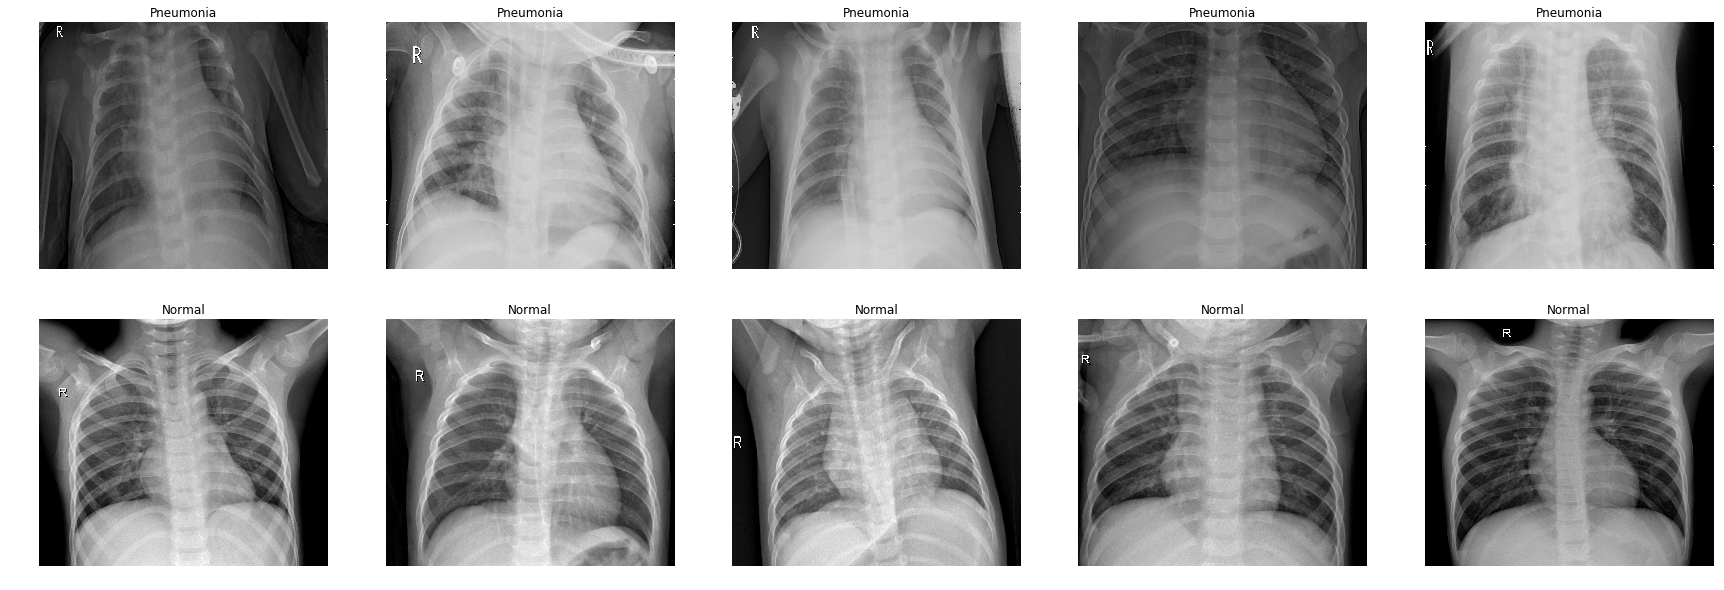

[[ 0  0  0 ... 23 24 25]
 [ 0  0  0 ... 25 26 27]
 [ 0  0  0 ... 28 29 30]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [10]:
# Get few samples for both the classes
pneumonia_samples = (train_data_df[train_data_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data_df[train_data_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()
print(img)

In [34]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_casos_lista = normal_cases_dir.glob('*.jpeg')
pneumonia_casos_lista = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_casos_lista:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (125,125))
    if img.shape[2] ==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_casos_lista:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (125,125))
    if img.shape[2] ==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 125, 125)
Total number of labels: (16, 2)


# Augmentation

In [35]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [48]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    print ("in the function")
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (125,125))
            
            # check if it is RGB
            if img.shape[2] ==3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [15]:
img = Image.open('/Users/jvivas/Documents/Kaggle/XRay Pneumonia/data/chest_xray/train/PNEUMONIA/person392_bacteria_1787.jpeg').convert('LA')

In [16]:
print (img)

<PIL.Image.Image image mode=LA size=1160x632 at 0x1C33AF4390>


In [20]:
# read the image and resize
img2 = img.resize((125, 125), Image.NEAREST)  # use nearest neighbou

In [25]:
# normalize the image pixels
arr = np.array(img2)

In [28]:
new_img = Image.fromarray(arr.astype('uint8'),'RGBA')
#img = arr.astype(np.float32)/255.

ValueError: buffer is not large enough

In [38]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [39]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [40]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [58]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data_df, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data_df.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [59]:
train_data_gen

<generator object data_gen at 0x1c332236d0>

In [ ]:
# plot first 36 images in MNIST
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y * 6])

Just like we did in Lab 4, we convert our training and testing labels into categorical binary arrays that replace the actual digits for a single bit in the right position.

### Building the CNN model

Now comes the most important part, where we build our CNN model. In the following implementation we have two convolutional layers, each of which uses a Rectifier Linear Unit (ReLU) activation. We also perform Max Pooling after each convolutional layer, and finally add two dense layers. We also use two dropout layers. 

Note that in the last part below, when we compile the model, we select the categorical cross-entropy as loss function (we are doing classification with more than two classes), and also use the `rmsprop` optimizer. This optimizer is similar to Stochastic Gradiend Descent, but you divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. This makes the optimization more efficient

After the next code cell, we explain what each of this layers does.

In [ ]:
print(np.shape(X_train))

In [1]:
# Import needed models and layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

/Users/jvivas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
img_size = (125,125,1) # Dimensions of the input volume
n_classes = 2       # Number of classes

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape = img_size, kernel_initializer = 'normal'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (5, 5), kernel_initializer = 'normal'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])


*The Convolutional Layer*

There is always a convolutional layer right after the input volume layer. Each of these layers has a number of filters or convolutional kernels (the number of filters is specified as the first argument in `Conv2D`, and its also know as the depth of the layer). The input image is convolved with each of these filters using a given stride (i.e., by how many positions the kernel moves in the input data before operating again). An activation function is added, usually a ReLu activation. The resulting output is called the activation map for that particular filter.

*Pooling*

This layer reduces the spatial dimensions (Width x Height) of the input volume for the next convolutional layer. It does not affect the depth dimension of the volume. The operation performed by this layer is also called ‘down-sampling’, as the reduction of size leads to loss of information as well. However, such a loss is beneficial for the network for two reasons:

* the decrease in size leads to less computational overhead for the upcoming layers of the network;
* it work against over-fitting.

The transformation is either performed by taking the maximum value from the values observable in the window (called ‘max pooling’), or by taking the average of the values.

*Dropout*

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. 

*Fully connected*

The Fully Connected layer is configured exactly the way its name implies: it is fully connected with the output of the previous layer. Fully-connected layers are typically used in the last stages of the CNN to connect to the output layer and construct the desired number of outputs, just like we did in the regular CNN. 

In [ ]:
print(np.shape(Y_train))

We now fit the model. We will use a batch size of 128 (so, 128 examples from the training set are used at each optimization step), will train for 10 epochs, and will select 20% of the training examples for validation at each validation. At each epoch, the training set will be randomly shuffled. In combination with the batch strategy, this will prevent us from getting stuck in a local minima of the loss function, as the training is never performed exactly on the same dataset at each epoch. We let the fitting routine print the progress.

In [ ]:
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 7, 
          validation_split = 0.2, verbose = 1)

As we train the model, we stop after each epoch to check on the validation loss, and see how it is behaving. In general, after an initial adjustment stage, the validation error should be higher than the training (since we should be doing better at classifying the data that we have seen during training).

In [ ]:
# ------------------------------------------------------------------------------
# Plot: Loss History during Training and Receiver-Operator Curve (ROC)
# ------------------------------------------------------------------------------

try:
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
except: 
    pass
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
epochs = np.arange(7)
fig, axis1 = plt.subplots(figsize=(10,6))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss History")
plt.legend(loc='upper right')
plt.tight_layout()


When do we stop training? Well, we want to make sure that we do not overfit, so we want to keep an eye on the validation error, and see if it starts rising again, since this would be an indication that the model is not good anymore at generalizing, and so it is not performing well in data that has not seem before (it makes many mistakes). This is known as *early stopping*.

Next, once we have trained long enough for the accuracy to be good, without going to far as to overfir, we test the accuracy on the test set:

In [ ]:
# Testing
score, acc = model.evaluate(X_test, Y_test, verbose = 1)
print(score)
print(acc)

In [ ]:
print (Y_test)

The next thing is to predict the labels for the test set, and visualize the mistakes we make by creating a confusion matrix. We predict by using the attribute `predict` of our model object:

In [ ]:
Y_pred = model.predict(X_test)
Y_pred

Note that the prediction is just the probability of each of the test examples belonging to the different classes. So we need to turn this back into categorical values by maximizing these probabilities. Let's print these predictions and compare with the true labels. Can you spot the errors?

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_real = []
Y_test_real = []
Y_prob = []
for i in range(len(Y_pred)):
    Y_pred_real.append(np.argmax(Y_pred[i], axis=None, out=None))
    Y_test_real.append(np.argmax(Y_test[i], axis=None, out=None))
    Y_prob.append(np.max(Y_pred[i]))
print(Y_pred_real)
print(Y_test_real)

Next, we use `sklearn` to find the confusion matrix, which is helpful to visualize where we make mistakes. In this case we did a pretty good job, but try reducing the size of your training set and see how your accuracy decreases

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# Get confusion matrix
cm = confusion_matrix(Y_test_real, Y_pred_real)

#Normalize it
cm_norm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# Plot it
plt.imshow(cm_norm, cmap = 'gray')
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, np.arange(n_classes), rotation=45)
plt.yticks(tick_marks, np.arange(n_classes))



plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Let's print a summary of our model

In [ ]:
# Visualizating filters
# https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
from keras import backend as K
K.set_learning_phase(1)
import tensorflow as tf


layer_dict = dict([(layer.name, layer) for layer in model.layers])
#print('Layer dict', layer_dict)
print(model.summary())

### What exactly does a CNN learn?
Now we will visualize the filters learned by the second convolutional network in our model, in order to see what type of features it is that the neural net is learning. We can extract the model filters easily. First we create a function that turns a tensor (the filters), into an image.

In [ ]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
layer_output = layer_dict['conv2d_2'].output

In [ ]:
print (layer_output)

Next, we extract each of the filters of the second CNN and plot them:

In [ ]:
def vis_img_in_filter(img = np.array(X_train[1]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

In [ ]:
vis_img_in_filter()

### Exercise
Play with the CNN! See how the different hyperparameters affect your accuracy.